# Implementation of  🤗 Transformers 

Today we're going to build on the knowledge learned yesterday and look in detail at the implementation of the `pipeline()` function and what is going on behind the scenes.

# Behind the pipeline

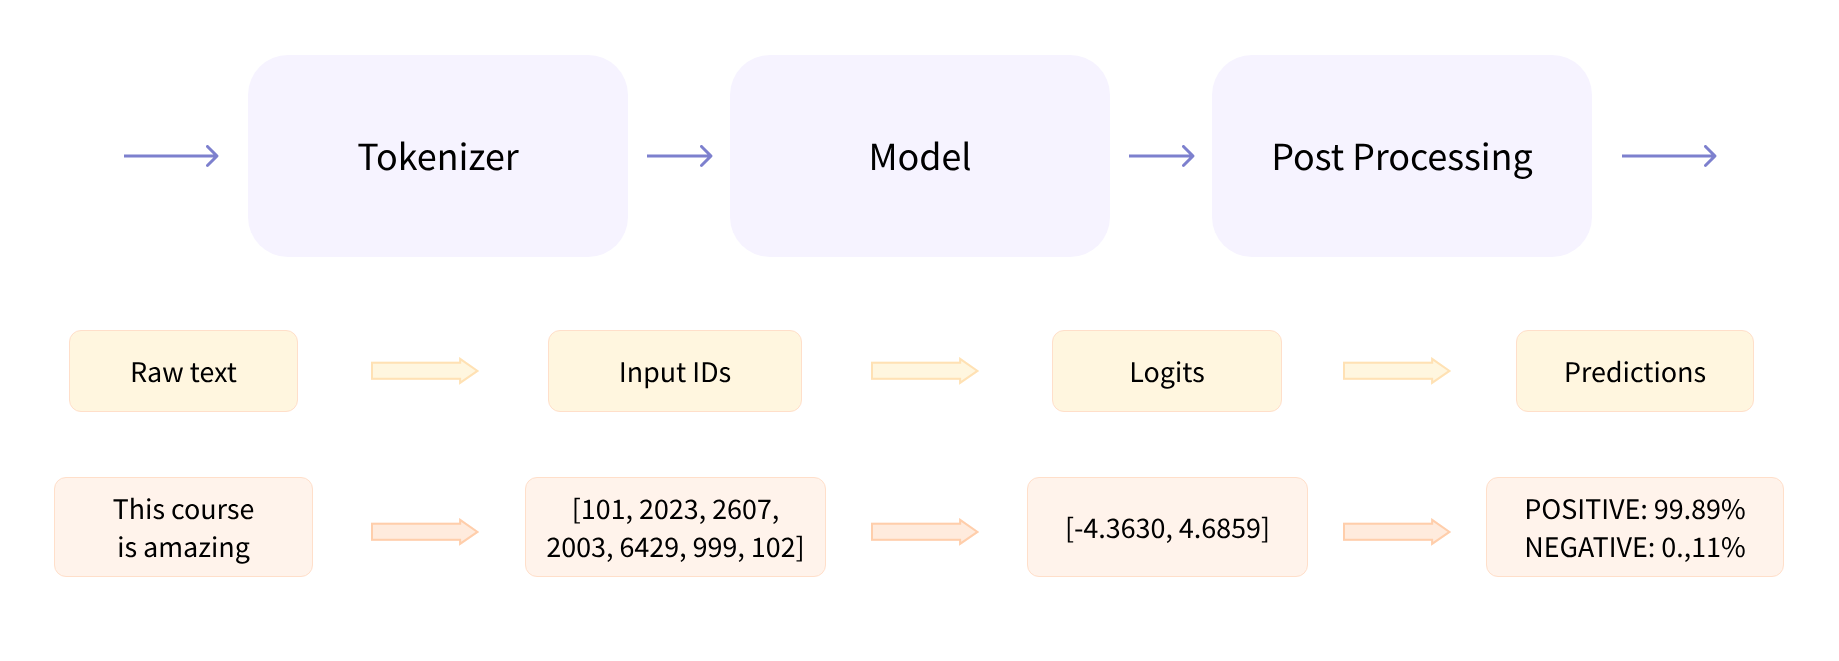

## Step 1: Convert text into numbers using a tokenizer

Transformer models can’t process raw text directly

First step of our pipeline is to convert the text inputs into numbers that the model can make sense of

All this preprocessing needs to be done in _exactly the same way_ as when the model was pretrained

To do this, we use the `AutoTokenizer` class and its `from_pretrained()` method 

Using the checkpoint name of our model, it will automatically fetch the data associated with the model’s tokenizer and cache it

In [ ]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
AutoTokenizer?

## Encoding text

Encoding Process Overview: Encoding translates text into numbers through a two-step process: tokenization followed by conversion to input IDs.

Tokenization Details: Initially, text is split into tokens (words, subwords, punctuation, etc.) using specific rules associated with the model's pretraining, necessitating the instantiation of the tokenizer with the model's name to ensure consistency.

Conversion to Input IDs: Tokens are then converted into numerical IDs based on a predefined vocabulary, obtained during tokenizer instantiation via the `from_pretrained()` method, to create a tensor for the model input, using the same vocabulary as in the model's pretraining for consistency.

Every word is allocated a unique ID, starting from 0 and extending to the full scope of the vocabulary.

The model employs these IDs to distinguish and recognize individual tokens.


## Word-level tokenization

A word-based tokenizer must assign an identifier to each word in a language, leading to a vast number of tokens due to the large vocabulary size (e.g., over 500,000 words in English).

Managing such a huge number of identifiers becomes a necessity to map each word to a unique input ID.

The tokenizer initially struggles to recognize similarities between related words (e.g., "dog" vs. "dogs" or "run" vs. "running"), treating them as unrelated entities.

## Handling Unknown Words in Tokenization

A custom token, typically denoted as `[UNK]` or `<unk>`, is used to represent words not found in the tokenizer's vocabulary.

Frequent occurrence of the “unknown” token indicates a failure in representing words effectively, leading to information loss. 

The aim is to minimize the use of this token by carefully constructing the vocabulary.

## Reminder of subword tokenization (BPE)

Subword tokenization algorithms prioritize keeping frequently used words intact while breaking down rare words into meaningful subwords to maintain semantic meaning and enhance vocabulary efficiency.

By decomposing words like “annoyingly” into “annoying” and “ly”, this approach retains the original word's meaning through its components, which are more likely to occur frequently as subwords.

This method significantly reduces the occurrence of unknown tokens and is particularly effective in agglutinative languages, enabling representation of complex words through a combination of smaller, meaningful subwords, thereby ensuring efficient and meaningful tokenization with smaller vocabularies.

Once we have the tokenizer, we can directly pass our sentences to it and we’ll get back a dictionary that’s ready to feed to our model! 

The only thing left to do is to convert the list of input IDs to tensors.

In [ ]:
import pprint

raw_inputs = [
    "I've been waiting for a HuggingFace course my whole life.",
    "Annoyingly I hate this so much!",
]
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="pt")
pprint.pprint(inputs)

In [ ]:
tokens1 = tokenizer.tokenize(raw_inputs[1])
print(tokens1)

In [ ]:
ids = tokenizer.convert_tokens_to_ids(tokens1)

print(ids)

## Decoding indices

Decoding Process: Decoding converts vocabulary indices back into a string using the `decode()` method.

Functionality of Decode Method: Beyond simple conversion, the `decode()` method reassembles tokens into their original word forms to create coherent and readable sentences

Critical for generating text or solving sequence-to-sequence tasks like translation or summarization.

In [ ]:
dec = tokenizer.decode(ids)
print(dec)

# Step 2: The Model

We can download our pretrained model the same way we did with our tokenizer

🤗 Transformers provides an `AutoModel` class which also has a `from_pretrained()` method

In [ ]:
from transformers import AutoModel

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModel.from_pretrained(checkpoint)

## Architectures vs. checkpoints

These terms have slightly different meanings:

- Architecture: This is the skeleton of the model — the definition of each layer and each operation that happens within the model.
- Checkpoints: These are the weights that will be loaded in a given architecture.
- Model: This is an umbrella term that isn’t as precise as “architecture” or “checkpoint”: it can mean both. 

For example, BERT is an architecture while bert-base-cased, a set of weights trained by the Google team for the first release of BERT, is a checkpoint. However, one can say “the BERT model” and “the bert-base-cased model.”

The  architecture contains only the base Transformer module

It needs some inputs in order to output *hidden states*

A high-dimensional vector representingthe contextual understanding of the input by the model

While these hidden states can be useful on their own, they’re usually inputs to another part of the model,  the head. 

Yesterday we saw that the different tasks could have been performed with the same architecture, but each of these tasks will have a different *head* associated with it.



## High-dimensional vectors

3 dimensions:

- Batch size: number of sequences processed at a time (2 in the above example)
- Sequence length: The length of the numerical representation of the sequence (16 in example)
- Hidden size: Vector dimension of each model input (ranging from 768 to 3072)

In [ ]:
outputs = model(**inputs)
print(outputs.last_hidden_state.shape)

## Model heads: making sense of the numbers

Heads take the high-dimensional vector of hidden states as input

Project them onto a different dimeension

Composed of a few linear layers:

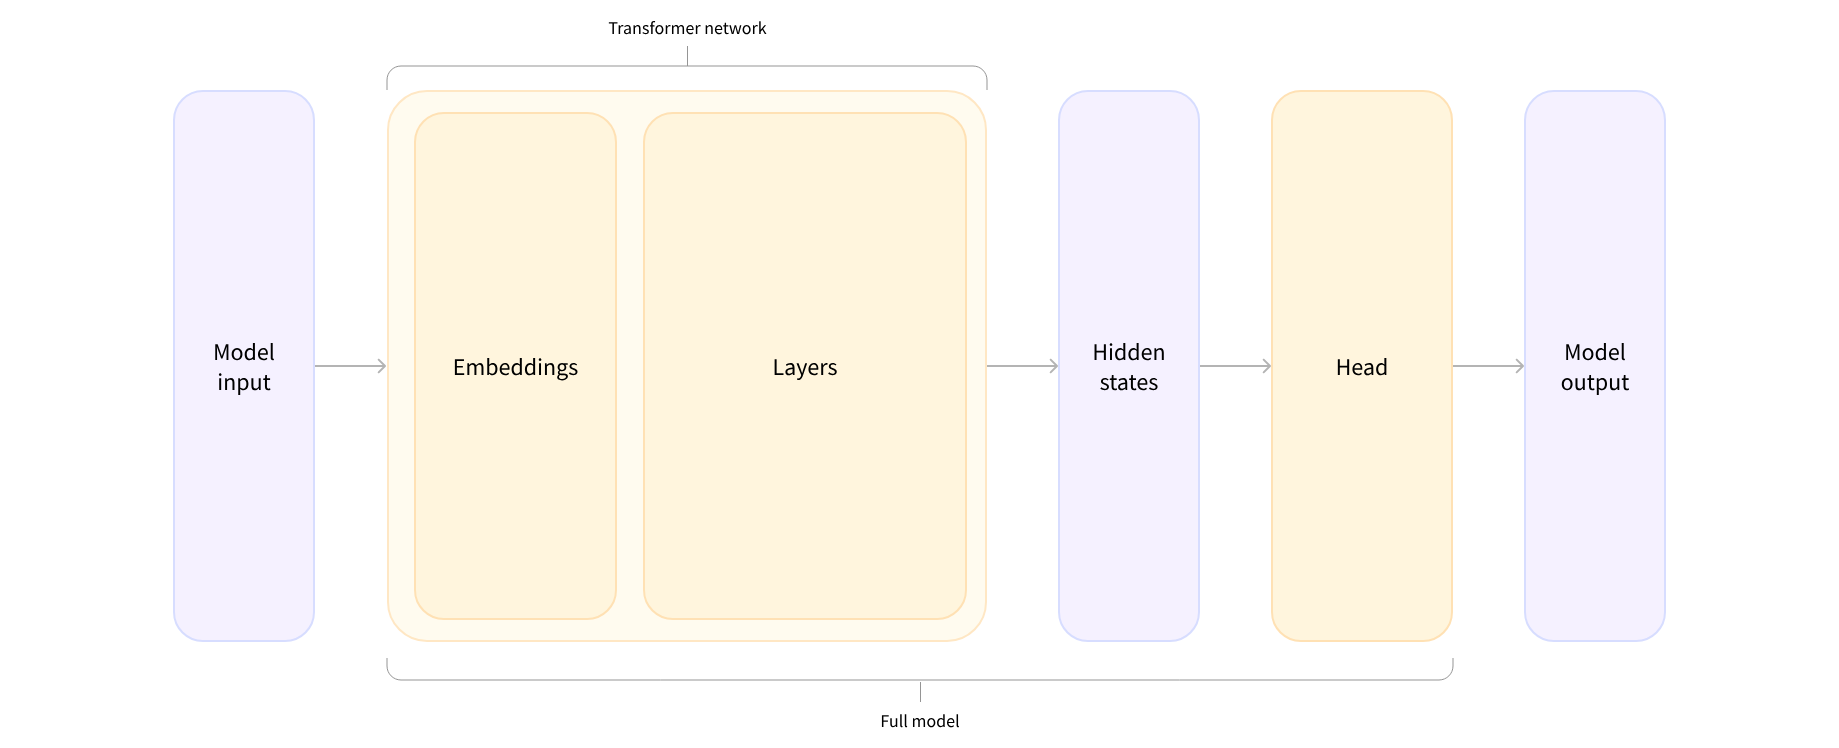

Embedding layer convert each Input ID in tokenized input into a vector represnting that token

Subsequent layers manipulate those vectors using attention mechanism

Produces final representation of sentences

There are many different architectures available in 🤗 Transformers, with each one designed around tackling a specific task. Here is a non-exhaustive list:

- *Model (retrieve the hidden states)
- *ForCausalLM
- *ForMaskedLM
- *ForMultipleChoice
- *ForQuestionAnswering
- *ForSequenceClassification
- *ForTokenClassification


For our example, we will need a model with a sequence classification head (to be able to classify the sentences as positive or negative). So, we won’t actually use the `AutoModel` class, but `AutoModelForSequenceClassification`:

In [ ]:
from transformers import AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
outputs = model(**inputs)

Now if we look at the shape of our outputs, the dimensionality will be much lower: 

The model head takes as input the high-dimensional vectors we saw before,

Outputs vectors containing two values (one per label):

In [ ]:
print(outputs.logits.shape)

## Postprocessing the outputs

The values we get back from the models don't make a lot of sense:

In [ ]:
print(outputs.logits)

Logits are the raw, unnormalized scores outputted by the last layer of the model 

Not probabilities

Need to go through SoftMax layer

In [ ]:
import torch

predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)

In [ ]:
model.config.id2label

Now we can conclude that the model predicted the following:

- First sentence: NEGATIVE: 0.0402, POSITIVE: 0.9598
- Second sentence: NEGATIVE: 0.9995, POSITIVE: 0.0005

So we have been through the 3 steps of the `pipeline()`:

1. Preprocessing with tokenizers
2. Passing the inputs through the model
3. Postprocessing to get sensible labels

# Models - Creating a Transformer

`AutoModel` class and relatives used as simple wrappers over a wide variety of models

If you know the type of model you can use particular class that defines its architecture directly

In [ ]:
from transformers import BertConfig, BertModel

# Building the config
config = BertConfig()

# Building the model from the config
model = BertModel(config)

In [ ]:
print(config)

Creating a model from the default configuration initializes it with random values

The model can be used in this state, but it will output gibberish; it needs to be trained first

We could train the model from scratch on the task at hand, problems?

To avoid unnecessary and duplicated effort, it’s imperative to be able to share and reuse models that have already been trained.


Loading a Transformer model that is already trained is simple — we can do this using the from_pretrained() method:

In [ ]:
from transformers import BertModel

model = BertModel.from_pretrained("bert-base-cased")

Loads a pretrained model via the bert-base-cased identifier. This is a model checkpoint that was trained by the authors of BERT themselves; you can find more details about it in its model card.

This model is now initialized with all the weights of the checkpoint. It can be used directly for inference on the tasks it was trained on, and it can also be fine-tuned on a new task. By training with pretrained weights rather than from scratch, we can quickly achieve good results.

The weights have been downloaded and cached (so future calls to the from_pretrained() method won’t re-download them) in the cache folder, which defaults to ~/.cache/huggingface/transformers. You can customize your cache folder by setting the HF_HOME environment variable.

The identifier used to load the model can be the identifier of any model on the Model Hub, as long as it is compatible with the BERT architecture. 

https://huggingface.co/models?other=bert

## Saving models

Saving a model is as easy as loading one — we use the save_pretrained() method, which is analogous to the from_pretrained() method:

In [ ]:
model.save_pretrained("directory_on_my_computer")

In [ ]:
!ls directory_on_my_computer

# Handling multiple sequences

In the previous example, we explored the simplest of use cases: doing inference on a single sequence of a small length. However, some questions emerge already:

- How do we handle multiple sequences?
- How do we handle multiple sequences of different lengths?
- Are vocabulary indices the only inputs that allow a model to work well?
- Is there such a thing as too long a sequence?

## Models expect a batch of inputs

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

sequence = "I've been waiting for a HuggingFace course my whole life."

tokens = tokenizer.tokenize(sequence)
ids = tokenizer.convert_tokens_to_ids(tokens)
input_ids = torch.tensor(ids)
# This line will fail.
model(input_ids)

## Why did this fail?

The problem is that we sent a single sequence to the model

🤗 Transformers models expect multiple sentences by default 

Tokenizer doesn’t just convert the list of input IDs into a tensor, it adds a dimension on top of it:

In [ ]:
tokenized_inputs = tokenizer(sequence, return_tensors="pt")
print(tokenized_inputs["input_ids"])

## Let's add that additional dimension and try again

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

sequence = "I've been waiting for a HuggingFace course my whole life."

tokens = tokenizer.tokenize(sequence)
ids = tokenizer.convert_tokens_to_ids(tokens)

input_ids = torch.tensor([ids])
print("Input IDs:", input_ids)

output = model(input_ids)
print("Logits:", output.logits)

*Batching* is the act of sending multiple sentences through the model, all at once. 

If you only have one sentence, you can just build a batch with a single sequence:

In [ ]:
batched_ids = [ids, ids]

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

sequence = "I've been waiting for a HuggingFace course my whole life."

tokens = tokenizer.tokenize(sequence)
ids = tokenizer.convert_tokens_to_ids(tokens)

input_ids = torch.tensor(batched_ids)
print("Input IDs:", input_ids)

output = model(input_ids)
print("Logits:", output.logits)

## Potential issue when batching

When you’re trying to batch together two (or more) sentences, they might be of different lengths. 

Tensors need to be of rectangular shape
 
To work around this problem, we usually *pad* the inputs

In [ ]:
#cannot be converted to a tensor
batched_ids = [
    [200, 200, 200],
    [200, 200]
]

In [ ]:
#use a padding token
padding_id = 100

batched_ids = [
    [200, 200, 200],
    [200, 200, padding_id],
]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

sequence1_ids = [[200, 200, 200]]
sequence2_ids = [[200, 200]]
batched_ids = [
    [200, 200, 200],
    [200, 200, tokenizer.pad_token_id],
]

print(model(torch.tensor(sequence1_ids)).logits)
print(model(torch.tensor(sequence2_ids)).logits)
print(model(torch.tensor(batched_ids)).logits)

The second row should be the same as the logits for the second sentence, but we’ve got completely different values!

This is because the key feature of Transformer models is attention layers that contextualize each token. 

These will take into account the padding tokens since they attend to all of the tokens of a sequence. 

To get the same result when passing individual sentences of different lengths through the model or when passing a batch with the same sentences and padding applied, we need to tell those attention layers to ignore the padding tokens. 

This is done by using an *attention mask*.O

In [ ]:
batched_ids = [
    [200, 200, 200],
    [200, 200, tokenizer.pad_token_id],
]

attention_mask = [
    [1, 1, 1],
    [1, 1, 0],
]

outputs = model(torch.tensor(batched_ids), attention_mask=torch.tensor(attention_mask))
print(outputs.logits)

## Longer sequences

There is a limit to the lengths of the sequences we can pass the models.

Most models handle sequences of up to 512 or 1024 tokens

Will crash when asked to process longer sequences

There are two solutions to this problem:



1. Use a model with a longer supported sequence length e.g Longformer
2. Truncate your sequences e.g specifying the `max_sequence_length` parameter

# Putting this all together

In [ ]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
#single sequence
sequence = "I've been waiting for a HuggingFace course my whole life."

model_inputs = tokenizer(sequence)
print(model_inputs)

In [ ]:
#multiple sequences
sequences = ["I've been waiting for a HuggingFace course my whole life.", "So have I!"]

model_inputs = tokenizer(sequences)
print(model_inputs)

In [ ]:
# Will pad the sequences up to the maximum sequence length
model_inputs = tokenizer(sequences, padding="longest")
print(model_inputs)

# Will pad the sequences up to the model max length
# (512 for BERT or DistilBERT)
model_inputs = tokenizer(sequences, padding="max_length")
print("====")
print(model_inputs)

# Will pad the sequences up to the specified max length
model_inputs = tokenizer(sequences, padding="max_length", max_length=8)

print("====")
print(model_inputs)

In [ ]:
sequences = ["I've been waiting for a HuggingFace course my whole life.", "So have I!"]

# Will truncate the sequences that are longer than the model max length
# (512 for BERT or DistilBERT)
model_inputs = tokenizer(sequences, truncation=True)
print("====")
print(model_inputs)

# Will truncate the sequences that are longer than the specified max length
model_inputs = tokenizer(sequences, max_length=8, truncation=True)
print("====")
print(model_inputs)

## Special Tokens

In [ ]:
sequence = "I've been waiting for a HuggingFace course my whole life."

model_inputs = tokenizer(sequence)
print(model_inputs["input_ids"])

tokens = tokenizer.tokenize(sequence)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

In [ ]:
print(tokenizer.decode(model_inputs["input_ids"]))
print(tokenizer.decode(ids))

The tokenizer added the special word [CLS] at the beginning and the special word [SEP] at the end. 

This is because the model was pretrained with those, so to get the same results for inference we need to add them as well. 

# Altogether now...

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
sequences = ["I've been waiting for a HuggingFace course my whole life.", "I hate hugging face"]

tokens = tokenizer(sequences, padding=True, truncation=True, return_tensors="pt")
output = model(**tokens)
predictions = torch.nn.functional.softmax(output.logits, dim=-1)
print(predictions)

In [ ]:
# Let's double check this matches the pipelines output...


# Summary

You've looked at the following:

- Learned the basic building blocks of a Transformer model.
- Learned what makes up a tokenization pipeline.
- Saw how to use a Transformer model in practice.
- Learned how to leverage a tokenizer to convert text to tensors that are understandable by the model.
- Set up a tokenizer and a model together to get from text to predictions.
- Learned the limitations of input IDs, and learned about attention masks.
- Played around with versatile and configurable tokenizer methods.